In [1]:
# Import dependencies
import matplotlib
import os
import numpy as np
from dimod import ConstrainedQuadraticModel, BinaryQuadraticModel, QuadraticModel, Binary, quicksum, Integer
from dwave.system import LeapHybridCQMSampler
import urllib.request
from collections import defaultdict
try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
import yaml
import urllib.request
from collections import defaultdict
from matplotlib.colors import hsv_to_rgb
from matplotlib.ticker import MultipleLocator
import random
from dotenv import load_dotenv, find_dotenv

In [2]:
# Load Environmental Variables
load_dotenv(find_dotenv())
token = os.environ['DWAVE_API_KEY'] 

In [3]:
def read_scenario(file_name):
    
    """A method that reads input instance file
    Args:
        instance_path:  path to the job shop instance file
    Returns:
        Job_dict: dictionary containing jobs as keys and a list of tuple of
                machines and their processing time as values.
    """
    job_dict = defaultdict(list)
    lines = urllib.request.urlopen(file_name)
    for i, line in enumerate(lines):
      info = line.decode('utf-8')
      if i == 0:
        num_jobs = int(line.split()[-1])
      elif i == 1:
          num_machines = int(line.split()[-1])
      elif 2 <= i <= 4:
          continue
      else:
        job_task = list(map(int, line.split()))
        job_dict[i - 5] = [x for x in
                            zip(job_task[1::2],  # machines
                                job_task[2::2]  # processing duration
                                )]
    return job_dict    

In [4]:
def build_cqm():
    
    """
    Build the Constrained Quadratic Model (CQM) for the scheduling problem.
    
    Returns:
        cqm (ConstrainedQuadraticModel): The constructed CQM.
    """
    
    cqm = ConstrainedQuadraticModel()
    cqm.set_objective(makespan)

    #  Constraint 1 : Ensures that the make span is at least the largest completion time of
            #the last operation of all jobs.
    for j in range(num_jobs):
        last_machine = jobtask_in_machine[(j, num_machines - 1)]
        cqm.add_constraint(
            makespan - x[(j, last_machine)] >=
            jobtask_duration[(j, num_machines - 1)],
            label='makespan_ctr{}'.format(j))
    
    #   Constraint 2: Precedence constraints ensures that all operations of a job are
        #  executed in the given order

    for j in range(num_jobs):  # job
        for t in range(1, num_machines):  # tasks
            machine_curr = jobtask_in_machine[(j, t)]
            machine_prev = jobtask_in_machine[(j, t - 1)]
            cqm.add_constraint(x[(j, machine_curr)] -
                    x[(j, machine_prev)]>= jobtask_duration[(j, t - 1)],
                                    label='pj{}_m{}'.format(j, t)
                                    )
        
    #  Constraint 3: Add quadratic constraints to ensure that no two jobs can be scheduled
            #on the same machine at the same time

    for j in range(num_jobs):
        for k in range(num_jobs):
            if j < k:
                for i in range(num_machines):
                    task_k = jobmachine_executes_task[(k, i)]
                    task_j = jobmachine_executes_task[(j, i)]
                    if jobtask_duration[k, task_k] > 0 and\
                            jobtask_duration[j, task_j] > 0:
                        cqm.add_constraint(
                            x[(j, i)] - x[(k, i)] + (
                                    jobtask_duration[k, task_k] -
                                    jobtask_duration[
                                        j, task_j]) * y[
                                (j, k, i)] + 2 * y[(j, k, i)] * (
                                    x[(k, i)] - x[(j, i)]) >=
                            jobtask_duration[(k, task_k)],
                            label='OneJobj{}_j{}_m{}'.format(j, k, i))
    return cqm


In [5]:
def solve(cqm, time_limit=10):
  
  """
    Solve the Constrained Quadratic Model (CQM) using the LeapHybridCQMSampler.

    Args:
        cqm (ConstrainedQuadraticModel): The CQM to solve.
        time_limit (int, optional): Time limit for the solver in seconds. Defaults to 10.

    Returns:
        dict: The best sample from the solution.
    """
  
  sampler = LeapHybridCQMSampler(token=token)
  print("Submitting CQM to solver {}.".format(sampler.solver.name))
  
  raw_sampleset = sampler.sample_cqm(cqm, label='JSS', time_limit=time_limit)
  feasible_sampleset = raw_sampleset.filter(lambda d: d.is_feasible)
  num_feasible = len(feasible_sampleset)
  if num_feasible > 0:
      best_samples = \
          feasible_sampleset.truncate(min(10, num_feasible))
  else:
      warnings.warn("Warning: Did not find feasible solution")
      best_samples = raw_sampleset.truncate(10)

  print(" \n" + "=" * 30 + "BEST SAMPLE SET" + "=" * 30)

  best_sample = best_samples.first.sample
  return best_sample

In [6]:
def parse_solution(best_sample):

    """
    Parse the best sample obtained from the solver.

    Args:
        best_sample (dict): The best sample from the solution.

    Returns:
        tuple: A tuple containing the solution dictionary and completion time.
        
    """        
    solution = {
            (j, i): (jobmachine_executes_task[(j, i)],
                     best_sample[x[(j, i)].variables[0]],
                     jobtask_duration[(j, jobmachine_executes_task[(j, i)])])
            for i in range(num_machines) for j in range(num_jobs)}

    completion_time = best_sample['makespan']
    
    return solution, completion_time

In [7]:
def plot_solution(solution: dict) -> tuple:

    """
    Plot the schedule for the given solution.

    Args:
        solution (dict): The solution dictionary.

    Returns:
        tuple: A tuple containing job_start_time and processing_time dictionaries.
    """

    
    job_start_time = defaultdict(list)
    processing_time = defaultdict(list)
    for j in range(num_jobs):
        job_start_time[j] = [solution[(j, i)][1] for i in
                             range(num_machines)]
        processing_time[j] = [
            jobtask_duration[j, jobmachine_executes_task[(j, i)]] for i in
            range(num_machines)]
    
    plot_schedule_core(job_start_time, processing_time)
    
    return job_start_time, processing_time

In [8]:
def plot_schedule_core(job_start_time: dict, processing_time: dict,) -> None:

    """
    Plot the schedule core based on job start times and processing times.

    Args:
        job_start_time (dict): Dictionary containing job start times.
        processing_time (dict): Dictionary containing job processing times.

    Returns:
        None
    """


    sols = np.array(list(job_start_time.values()))
    durs = np.array(list(processing_time.values()))
    solsT = sols.transpose()
    dursT = durs.transpose()
    n, m = sols.shape
    labels = ['machine ' + str(i) for i in range(m)]
    category_names = ['job ' + str(i) for i in range(n)]

    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, sols.shape[0]))
    fig, ax = plt.subplots()
    ax.invert_yaxis()
    ax.xaxis.set_visible(True)

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = dursT[:, i]
        starts = solsT[:, i]
        ax.barh(labels, widths, left=starts, height=.5,
                label=colname)
        xcenters = starts + widths / 2
        r, g, b, _ = color
        text_color = 'white'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            if c > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center',
                        color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    plt.draw()

In [9]:
# Read the data in
filename = 'https://raw.githubusercontent.com/dwave-examples/job-shop-scheduling-cqm/main/input/instance5_8.txt'
jobs = read_scenario(filename)

In [10]:
# Refactor the data
max_makespan = 0
jobtask_duration = {}
jobtask_in_machine = {}
jobmachine_executes_task = {}

for j, val in jobs.items():
  for i, (machine, duration) in enumerate(val):
    jobtask_in_machine[(j, i)] = machine
    jobtask_duration[(j, i)] = duration
    jobmachine_executes_task[(j, machine)] = i

num_jobs = len(jobs)
num_machines = len(jobs[0])

# Calculate a trivial upper bound for make span
max_makespan = sum(jobtask_duration[(j, i)]
                        for j in range(num_jobs) for i in
                        range(num_machines))

In [11]:
# Define make span as an integer variable
makespan = Integer("makespan", lower_bound=0,
                            upper_bound=max_makespan)

# Define integer variable for start time of using machine i for job j
x = {
    (j, i): Integer('x{}_{}'.format(j, i), lower_bound=0,
                    upper_bound=max_makespan)
    for j in range(num_jobs) for i in range(num_machines)}

# Add binary variable which equals to 1 if job j precedes job k on machine i
y = {(j, k, i): Binary('y{}_{}_{}'.format(j, k, i))
                for j in range(num_jobs)
                for k in range(num_jobs) for i in
                range(num_machines)}

Submitting CQM to solver hybrid_constrained_quadratic_model_version1.
 
==============================BEST SAMPLE SET==============================
Completion time of the process is: 68.0


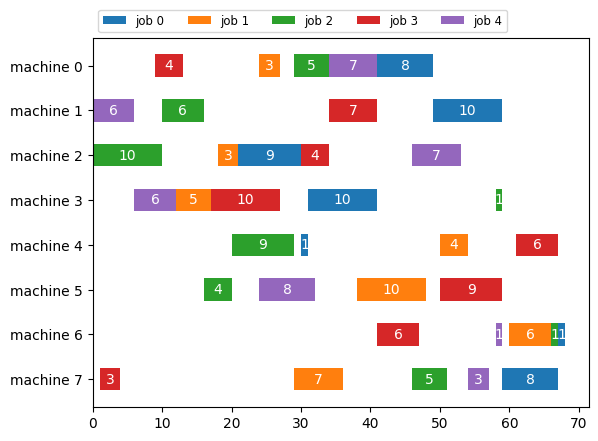

In [12]:
# Initialize CQM
cqm = build_cqm()

# Instantiate the sampler
best_sample = solve(cqm)

# Parse solution
solution, completion_time = parse_solution(best_sample)

# Print solution in a human readable diagram
plot_solution(solution)
print(f'Completion time of the process is: {completion_time}')